In [1]:
%config InlineBackend.figure_formats = ['svg']
import quimb.tensor as qtn
import quimb as qu
import cotengra as ctg
import autoray as ar
import register_ as reg
import algo_cooling as algo
import quf
import time
import numpy as np
from tqdm import tqdm
import nlopt
import torch
from torch.nn.utils import parameters_to_vector, vector_to_parameters
from quimb.tensor.belief_propagation.l2bp import L2BP


import matplotlib as mpl
import matplotlib.pyplot as plt


In [2]:
reg.reg_complex_svd()

to_backend = algo.backend_torch(device = "cpu", dtype = torch.float64, requires_grad=False)
to_backend_c = algo.backend_torch(device = "cpu", dtype = torch.complex128, requires_grad=False)
to_backend_ = algo.backend_torch(device = "cpu", dtype = torch.float64, requires_grad=False)

opt = algo.opt_(progbar=False, max_time="rate:1e9", max_repeats=128, optlib="cmaes")


In [3]:
info_bp = qu.load_from_disk(f"store_state/info_bp")


In [4]:
#ITF params
J, h, chi, dt, depth = info_bp["J"], info_bp["h"], info_bp["chi"], info_bp["dt"], info_bp["depth"]
Lx, Ly, L = info_bp["Lx"], info_bp["Ly"], info_bp["L"]
t = depth * dt
print("t", t, "chi", chi, "depth", depth)

t 1.0 chi 12 depth 20


In [5]:
pepo, edges, sites  = info_bp["pepo"], info_bp["edges"], info_bp["sites"]

In [6]:
(pepo.H & pepo).contract(all, optimize=opt)

tensor(4100.2338-2.8588e-13j, dtype=torch.complex128)

In [7]:


depth_total = 10
params = {}

dt_guess = 0.05
for depth in range(depth_total):
        params[f"rx_depth{depth}"] = to_backend_( torch.tensor( -h * dt_guess ).clone().detach() )
        params[f"rzz_depth{depth}"] = to_backend_( torch.tensor( -J * 2 * dt_guess ).clone().detach() )




/home/reza.haghshenas@quantinuum.com/time_compressed_algo/algo_cooling.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype=dtype, device=device, requires_grad=requires_grad)


In [8]:
%%time
pepo_t = algo.pepo_trotter_ITF(edges, sites, depth=1,
                     Lx=Lx, Ly=Ly, to_backend=to_backend_c, params=params)

CPU times: user 6.66 s, sys: 0 ns, total: 6.66 s
Wall time: 188 ms


In [9]:
%%time
chi = 12

pbar = tqdm(total=depth_total, desc="BP", ncols=100, dynamic_ncols=True)
t = dt
results = {"t": [], "Bp_norm": [], "Error": []}

for step in range(depth_total):
    t += dt
    pepo_t = algo.pepo_trotter_ITF(edges, sites, depth=step, Lx=Lx, Ly=Ly, to_backend=to_backend_c, params=params)
    pepo = algo.apply_pepo(pepo, pepo_t, flat=False)
    
    
    bp = L2BP(pepo, site_tags=list(pepo.site_tags), damping=0.0, optimize=opt, 
              normalize = 'L2phased', update='parallel',
             )
    bp.run(tol=1.e-7, max_iterations=2000, progbar=False, diis = True)
    pepo = bp.compress(pepo, max_bond=chi, cutoff=1.-12, cutoff_mode="rsum2", renorm=0, lazy=False)
    
    est_norm = complex(bp.contract()).real
    
    # stable norm: 
    log_val = np.log(est_norm) + (2 * complex(pepo.exponent).real * np.log(10)) - (L * np.log(2))
    bpnorm = np.exp(log_val)

    results.setdefault("Bp_norm", []).append(bpnorm)
    results.setdefault("Error", []).append(1  -  (np.log(bpnorm) / L))
    results.setdefault("t", []).append(t)

    print(  (pepo.H & pepo).contract(all, optimize=opt)/ (2**L) )
    
    pbar.set_postfix({
        "t":       f"{round(t,2)}",
        "Bp_norm":  "—" if not len(results["Bp_norm"]) else round(bpnorm, 4),
        "Error":  "—" if not len(results["Error"]) else round(bpnorm, 4),

    })
    pbar.update(1)
    


BP:  10%|██████▊                                                             | 1/10 [00:02<00:19,  2.18s/it, t=0.1, Bp_norm=1, Error=1]

tensor(1.0008+8.6984e-17j, dtype=torch.complex128)


BP:  20%|█████████████▍                                                     | 2/10 [00:03<00:13,  1.71s/it, t=0.15, Bp_norm=1, Error=1]

tensor(1.0005+8.2612e-17j, dtype=torch.complex128)


BP:  30%|████████████████████▍                                               | 3/10 [00:18<00:53,  7.71s/it, t=0.2, Bp_norm=1, Error=1]

tensor(1.0002-4.1967e-17j, dtype=torch.complex128)


BP:  40%|██████████████████████████▊                                        | 4/10 [00:43<01:27, 14.54s/it, t=0.25, Bp_norm=1, Error=1]

tensor(0.9999+3.5518e-17j, dtype=torch.complex128)


BP:  50%|██████████████████████████████████                                  | 5/10 [01:13<01:40, 20.07s/it, t=0.3, Bp_norm=1, Error=1]

tensor(0.9998+1.2670e-17j, dtype=torch.complex128)


BP:  60%|████████████████████████████████████████▏                          | 6/10 [01:42<01:33, 23.32s/it, t=0.35, Bp_norm=1, Error=1]

tensor(0.9997+6.2805e-17j, dtype=torch.complex128)


BP:  70%|███████████████████████████████████████████████▌                    | 7/10 [02:09<01:12, 24.28s/it, t=0.4, Bp_norm=1, Error=1]

tensor(0.9996+3.2674e-17j, dtype=torch.complex128)


BP:  80%|█████████████████████████████████████████████████████▌             | 8/10 [02:38<00:51, 25.99s/it, t=0.45, Bp_norm=1, Error=1]

tensor(0.9996-1.7934e-17j, dtype=torch.complex128)


BP:  90%|█████████████████████████████████████████████████████████████▏      | 9/10 [03:28<00:33, 33.37s/it, t=0.5, Bp_norm=1, Error=1]

tensor(1.2349+3.6434e-17j, dtype=torch.complex128)


BP: 100%|██████████████████████████████████████████████████████████| 10/10 [04:38<00:00, 44.63s/it, t=0.55, Bp_norm=0.224, Error=0.224]

tensor(0.9769-1.8525e-16j, dtype=torch.complex128)
CPU times: user 54min 3s, sys: 7min 8s, total: 1h 1min 11s
Wall time: 4min 38s


In [10]:
results["Bp_norm"]

[0.9998034652732968,
 0.9997104865919404,
 0.9996632254023443,
 0.9996404923176024,
 0.9996300478109326,
 0.9996254671855449,
 0.9996235601224889,
 0.9996227780790345,
 0.9996224123627923,
 0.22372805304432117]

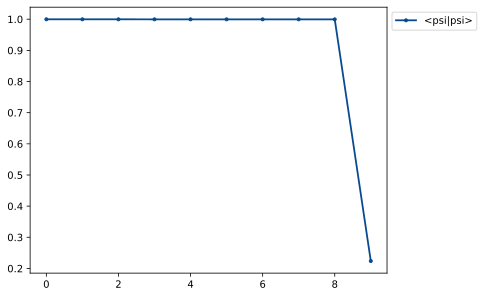

In [11]:
if results["Bp_norm"]:
    plt.plot(
        results["Bp_norm"],
        ".-",
        label=f"<psi|psi>",
        color=mpl.cm.Blues((8 + 1) / 10),
        linewidth=2 * (8 + 1) / 10,
    )
    
    
    plt.legend(bbox_to_anchor=(1, 1))
    plt.show()
    plt.close()

In [12]:
pepo = algo.trace_2d(pepo, Lx, Ly)
pepo.show()

   12   12   12   
 ●━━━━●━━━━●━━━━●
 ┃12  ┃12  ┃12  ┃12 
 ┃ 12 ┃ 12 ┃ 12 ┃ 
 ●━━━━●━━━━●━━━━●
 ┃12  ┃12  ┃12  ┃12 
 ┃ 12 ┃ 12 ┃ 12 ┃ 
 ●━━━━●━━━━●━━━━●
                    


In [13]:
overlap = pepo.contract(all, optimize=opt, strip_exponent=False)
complex(overlap).real

-1.0384799114426746

In [14]:
pepo.contract_boundary_( max_bond=int(1.5*chi), final_contract = True, 
                               final_contract_opts={"optimize":opt}, 
                               max_separation = 1, 
                               sequence = ['xmin', 'xmax', "ymin", "ymax" ], 
                               equalize_norms=False, progbar=True,
                               )    
complex(pepo^all).real


0it [00:00, ?it/s]
contracting boundary, Lx=3, Ly=4: : 0it [00:00, ?it/s]
contracting xmin, Lx=3, Ly=4: : 0it [00:00, ?it/s]    
contracting xmin, Lx=3, Ly=4: : 1it [00:09,  9.36s/it]
contracted boundary, Lx=2, Ly=4: : 1it [00:09,  9.37s/it]


-1.0383788047048974

In [15]:
pepo.exponent

0.0

In [16]:
stable = True
if stable:
    trace_, exponent = pepo.contract(all, optimize=opt, strip_exponent=True)
    log_ratio = ar.do("log", abs(trace_)) + exponent * ar.do("log",10) - L * ar.do("log",2)
    ratio =  ar.do("exp",log_ratio)  # = abs(val) / 2**L, stably
    cost = 1 - ratio
else:
    overlap = pepo.contract(all, optimize=opt, strip_exponent=False)
    cost = 1 - ( ar.do("abs", overlap) / 2**L )
cost

tensor(0.9997, dtype=torch.float64)

In [17]:
stable = False
if stable:
    trace_, exponent = pepo.contract(all, optimize=opt, strip_exponent=True)
    log_ratio = ar.do("log", abs(trace_)) + exponent * ar.do("log",10) - L * ar.do("log",2)
    ratio =  ar.do("exp",log_ratio)  # = abs(val) / 2**L, stably
    cost = 1 - ratio
else:
    overlap = pepo.contract(all, optimize=opt, strip_exponent=False)
    cost = 1 - ( ar.do("abs", overlap) / 2**L )
cost

tensor(0.9997, dtype=torch.float64)